In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, shutil, pathlib

from tensorflow import keras
from tensorflow.keras import layers

# data processing
from tensorflow.keras.utils import image_dataset_from_directory

## Loading and Preprocessing the Data

In [2]:
!kaggle competitions download -c dogs-vs-cats

100%|███████████████████████████████████████▉| 811M/812M [01:54<00:00, 6.75MB/s]
100%|████████████████████████████████████████| 812M/812M [01:54<00:00, 7.44MB/s]


In [3]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [4]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [5]:
!rm -r train train.zip test1.zip dogs-vs-cats.zip sampleSubmission.csv

In [6]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Metal device set to: Apple M2
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## ConvNet from Scratch 

In [7]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


2023-05-19 14:37:59.740179: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


63/63 [==============================] - 8s 111ms/step - loss: 0.7506 - accuracy: 0.5125 - val_loss: 0.6909 - val_accuracy: 0.5030
Epoch 2/30
63/63 [==============================] - 7s 105ms/step - loss: 0.7140 - accuracy: 0.5465 - val_loss: 0.7690 - val_accuracy: 0.5080
Epoch 3/30
63/63 [==============================] - 7s 105ms/step - loss: 0.6906 - accuracy: 0.6130 - val_loss: 0.6895 - val_accuracy: 0.5880
Epoch 4/30
63/63 [==============================] - 7s 108ms/step - loss: 0.6651 - accuracy: 0.6565 - val_loss: 0.6593 - val_accuracy: 0.6180
Epoch 5/30
63/63 [==============================] - 7s 109ms/step - loss: 0.6119 - accuracy: 0.6865 - val_loss: 0.6196 - val_accuracy: 0.6700
Epoch 6/30
63/63 [==============================] - 7s 113ms/step - loss: 0.5873 - accuracy: 0.7045 - val_loss: 0.5904 - val_accuracy: 0.6910
Epoch 7/30
63/63 [==============================] - 7s 106ms/step - loss: 0.5566 - accuracy: 0.7210 - val_loss: 0.5908 - val_accuracy: 0.6950
Epoch 8/30
63/63 

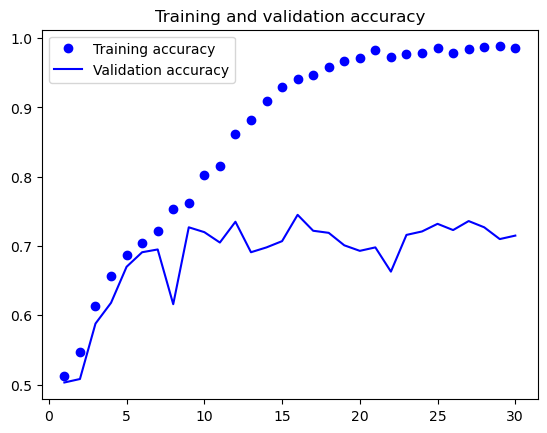

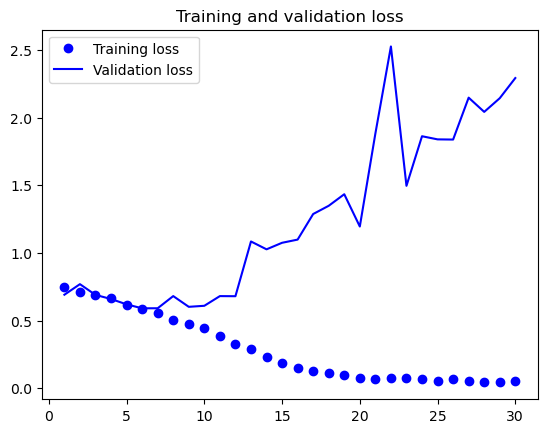

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
# Evaluating the model on the test set

test_model = keras.models.load_model("models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 31ms/step - loss: 0.5988 - accuracy: 0.6755
Test accuracy: 0.675


## ConvNet with Data Augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

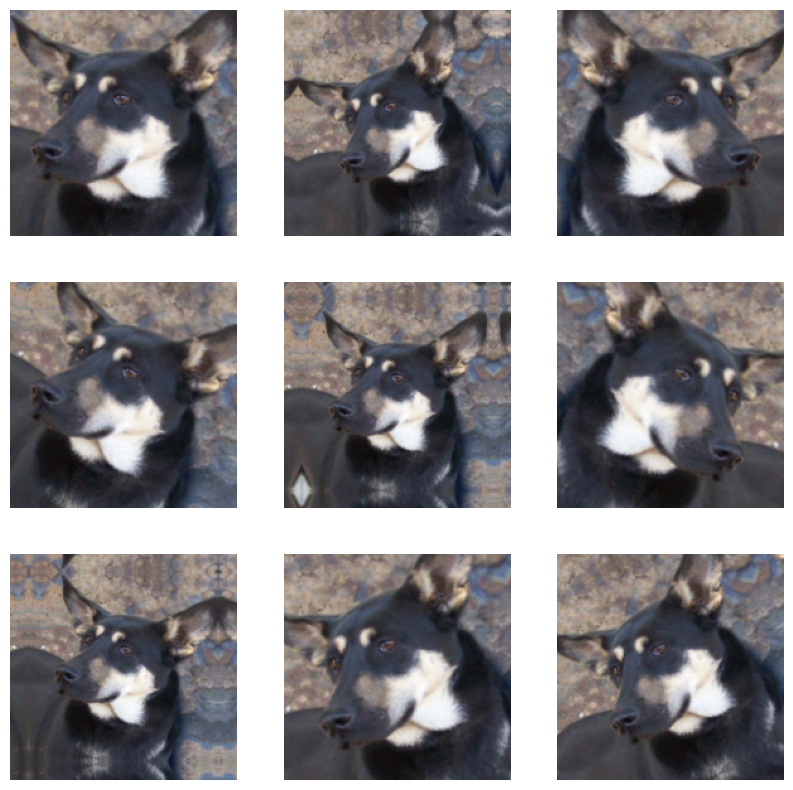

In [ ]:
# Displaying some randomly augmented training images

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 136ms/step - loss: 0.7153 - accuracy: 0.5205 - val_loss: 0.6897 - val_accuracy: 0.5170
Epoch 2/100
63/63 [==============================] - 8s 129ms/step - loss: 0.7053 - accuracy: 0.5470 - val_loss: 0.6738 - val_accuracy: 0.5460
Epoch 3/100
63/63 [==============================] - 8s 129ms/step - loss: 0.6924 - accuracy: 0.5790 - val_loss: 0.6696 - val_accuracy: 0.5850
Epoch 4/100
63/63 [==============================] - 8s 129ms/step - loss: 0.6594 - accuracy: 0.6245 - val_loss: 0.6913 - val_accuracy: 0.5580
Epoch 5/100
63/63 [==============================] - 9s 137ms/step - loss: 0.6815 - accuracy: 0.6480 - val_loss: 0.6207 - val_accuracy: 0.6420
Epoch 6/100
63/63 [==============================] - 8s 133ms/step - loss: 0.6284 - accuracy: 0.6790 - val_loss: 0.5947 - val_accuracy: 0.6700
Epoch 7/100
63/63 [==============================] - 9s 140ms/step - loss: 0.6091 - accuracy: 0.6690 - val_loss: 0.5961 - val_accuracy: 0.6660

Epoch 58/100
63/63 [==============================] - 8s 132ms/step - loss: 0.2297 - accuracy: 0.9080 - val_loss: 0.4306 - val_accuracy: 0.8330
Epoch 59/100
63/63 [==============================] - 8s 129ms/step - loss: 0.1929 - accuracy: 0.9215 - val_loss: 0.5842 - val_accuracy: 0.8310
Epoch 60/100
63/63 [==============================] - 8s 132ms/step - loss: 0.2309 - accuracy: 0.9095 - val_loss: 0.5003 - val_accuracy: 0.8260
Epoch 61/100
63/63 [==============================] - 8s 130ms/step - loss: 0.2164 - accuracy: 0.9145 - val_loss: 0.5961 - val_accuracy: 0.8130
Epoch 62/100
63/63 [==============================] - 8s 127ms/step - loss: 0.2255 - accuracy: 0.9135 - val_loss: 0.7755 - val_accuracy: 0.7880
Epoch 63/100
63/63 [==============================] - 8s 127ms/step - loss: 0.2076 - accuracy: 0.9175 - val_loss: 0.4992 - val_accuracy: 0.8290
Epoch 64/100
63/63 [==============================] - 8s 127ms/step - loss: 0.2309 - accuracy: 0.9140 - val_loss: 0.8714 - val_accuracy:

In [17]:
# Evaluating the model on the test set

test_model = keras.models.load_model(
    "models/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 34ms/step - loss: 0.4583 - accuracy: 0.8640
Test accuracy: 0.864


## Leveraging a Pretrained Model

 We Shall proceed with two different approaches: The first is fast and cheap to run and depends on extracting the features from a trained model and then train a new classifier on the top of these extracted features. The second the convolution base of a trained model by adding dense layers on top, and run the whole thing from end to end on the input data.
 
We shall use VGG16 in both approaches.

### Feature extraction with a pretrained model

In [18]:
# Extracting the VGG16 features and corresponding labels

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

In [20]:
# Fast feature extraction without data augmentation

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 18ms/step


In [21]:
train_features.shape

(2000, 5, 5, 512)

In [22]:
# Defining and training the densely connected classifier

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 18.0160 - accuracy: 0.9225 - val_loss: 3.3950 - val_accuracy: 0.9640
Epoch 2/20
63/63 [==============================] - 1s 12ms/step - loss: 4.2778 - accuracy: 0.9690 - val_loss: 7.2624 - val_accuracy: 0.9570
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 2.3079 - accuracy: 0.9860 - val_loss: 7.7367 - val_accuracy: 0.9580
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.6382 - accuracy: 0.9850 - val_loss: 4.1877 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.1765 - accuracy: 0.9920 - val_loss: 4.3189 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.3894 - accuracy: 0.9970 - val_loss: 5.4475 - val_accuracy: 0.9730
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.5630 - accuracy: 0.9940 - val_loss: 5.7814 - val_accuracy: 0.9720
Epoch 8/20
6

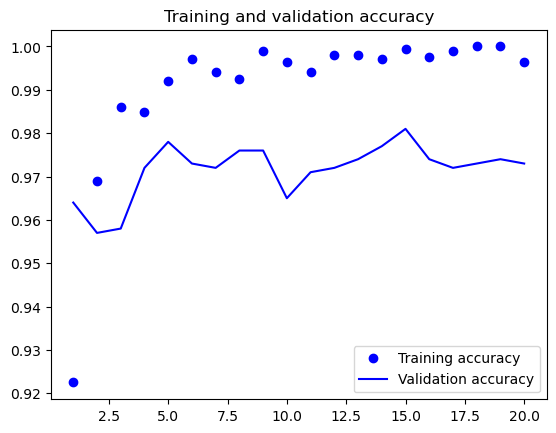

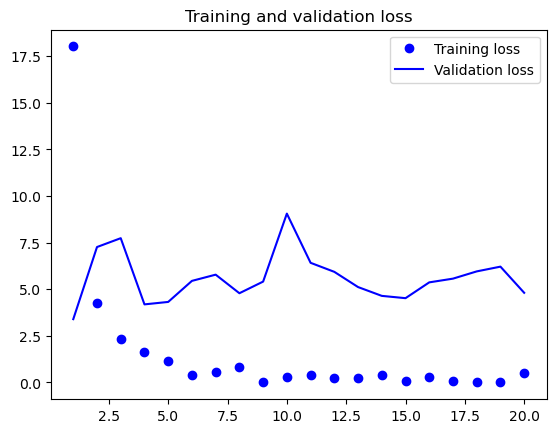

In [23]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

In [24]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 41s 623ms/step - loss: 20.6901 - accuracy: 0.8880 - val_loss: 5.4518 - val_accuracy: 0.9630
Epoch 2/50
63/63 [==============================] - 36s 574ms/step - loss: 8.3837 - accuracy: 0.9400 - val_loss: 4.3131 - val_accuracy: 0.9680
Epoch 3/50
63/63 [==============================] - 35s 551ms/step - loss: 6.0755 - accuracy: 0.9550 - val_loss: 5.1772 - val_accuracy: 0.9640
Epoch 4/50
63/63 [==============================] - 38s 603ms/step - loss: 4.9552 - accuracy: 0.9590 - val_loss: 4.6439 - val_accuracy: 0.9690
Epoch 5/50
63/63 [==============================] - 37s 584ms/step - loss: 4.5180 - accuracy: 0.9635 - val_loss: 3.9503 - val_accuracy: 0.9700
Epoch 6/50
63/63 [==============================] - 35s 551ms/step - loss: 2.8239 - accuracy: 0.9700 - val_loss: 4.0698 - val_accuracy: 0.9720
Epoch 7/50
63/63 [==============================] - 36s 573ms/step - loss: 2.2962 - accuracy: 0.9755 - val_loss: 3.7767 - val_accuracy: 0.978

In [27]:
# Evaluating the model on the test set

test_model = keras.models.load_model(
    "models/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 23s 365ms/step - loss: 1.1270 - accuracy: 0.9720
Test accuracy: 0.972


### Fine-tuning a pretrained model

In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [29]:
# Freezing all layers until the fourth from the last

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [30]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 46s 722ms/step - loss: 0.3532 - accuracy: 0.9870 - val_loss: 1.2136 - val_accuracy: 0.9750
Epoch 2/30
63/63 [==============================] - 42s 669ms/step - loss: 0.1723 - accuracy: 0.9915 - val_loss: 1.0361 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 42s 668ms/step - loss: 0.1079 - accuracy: 0.9945 - val_loss: 1.2525 - val_accuracy: 0.9790
Epoch 4/30
63/63 [==============================] - 40s 630ms/step - loss: 0.1024 - accuracy: 0.9935 - val_loss: 0.8224 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 40s 636ms/step - loss: 0.2095 - accuracy: 0.9905 - val_loss: 0.7942 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 55s 878ms/step - loss: 0.3026 - accuracy: 0.9880 - val_loss: 0.7397 - val_accuracy: 0.9800
Epoch 7/30
63/63 [==============================] - 31s 491ms/step - loss: 0.1213 - accuracy: 0.9945 - val_loss: 0.8638 - val_accuracy: 0.9790

In [31]:
# Evaluating the model on the test set

model = keras.models.load_model("models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 23s 369ms/step - loss: 0.8339 - accuracy: 0.9740
Test accuracy: 0.974
